In [2]:
# if necessary, install NeuralGCM and dependencies
! pip install -q -U neuralgcm dinosaur gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.0/171.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 147.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.


In [21]:
! pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 57.3 MB/s eta 0:00:00


# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/neuralgcm/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [3]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

In [22]:
import geopandas as gpd
import rioxarray as rio # Import rioxarray
from shapely.geometry import mapping # Import mapping

## Load a pre-trained NeuralGCM model

By default, this notebook uses the intermediate 1.4° deterministic NeuralGCM model.

[Other available checkpoints](./checkpoints.md) include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations, as well as 2.8° stochastic models that predict precipitation. All models are licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/).

In [4]:
model_name = 'v1/deterministic_1_4_deg.pkl'  #@param ['v1/deterministic_0_7_deg.pkl', 'v1/deterministic_1_4_deg.pkl', 'v1/deterministic_2_8_deg.pkl', 'v1/stochastic_1_4_deg.pkl', 'v1_precip/stochastic_precip_2_8_deg.pkl', 'v1_precip/stochastic_evap_2_8_deg.pkl'] {type: "string"}

gcs = gcsfs.GCSFileSystem(token='anon')
with gcs.open(f'gs://neuralgcm/models/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Load ERA5 data from GCP/Zarr

See {doc}`data_preparation` for details.

Select out a few days of data from ERA5:

In [5]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(
    era5_path, chunks=None, storage_options=dict(token='anon')
)

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM's native resolution:

In [6]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast

See {doc}`trained_models` for details.

In [7]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

In [26]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

In [10]:
combined_ds

<xarray.Dataset> Size: 272MB
Dimensions:                              (model: 2, time: 4, level: 37,
                                          longitude: 256, latitude: 128)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * time                                 (time) int64 32B 0 24 48 72
  * model                                (model) <U9 72B 'ERA5' 'NeuralGCM'
Data variables:
    geopotential                         (model, time, level, longitude, latitude) float32 39MB ...
    specific_cloud_liquid_water_content  (model, time, level, longitude, latitude) float32 39MB ...
    specific_humidity                    (model, time, level, longitude, latitude) float32 39MB ...
    temperature                          (model, time, level, longitude, latitude) float32 39MB ...
    specific_cloud_ice_water_content     (model, time, level, longitude, latitude) float32 39MB ...
    sim_time                             (model, time) float32 32B ...
    u_component_of_wind                  (model, time, level, longitude, latitude) float32 39MB ...
    v_component_of_wind                  (model, time, level, longitude, latitude) float32 39MB ...
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

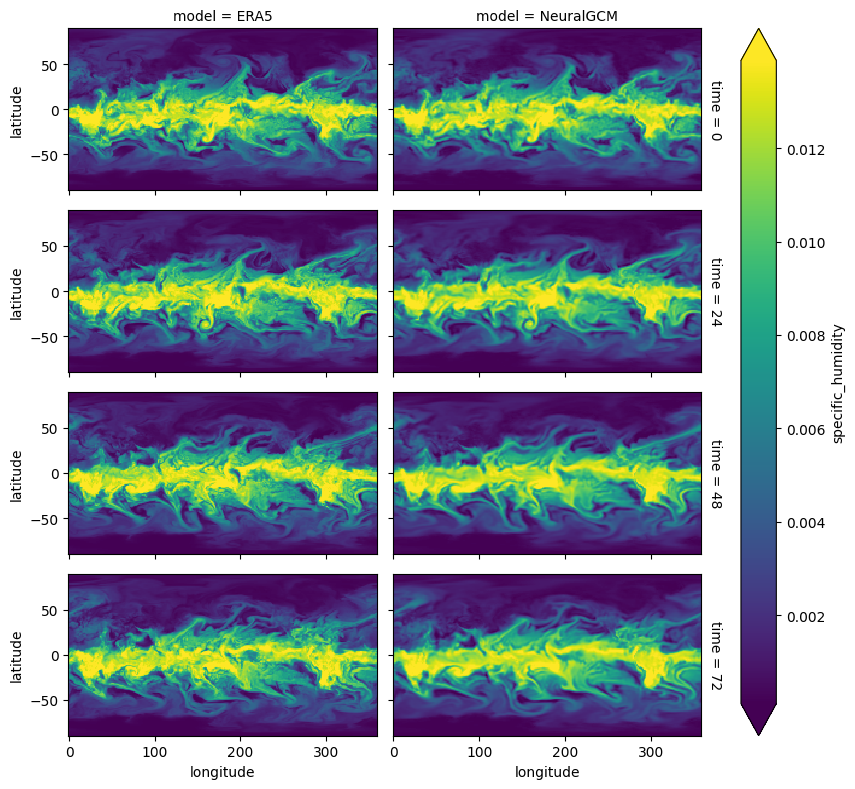

In [9]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

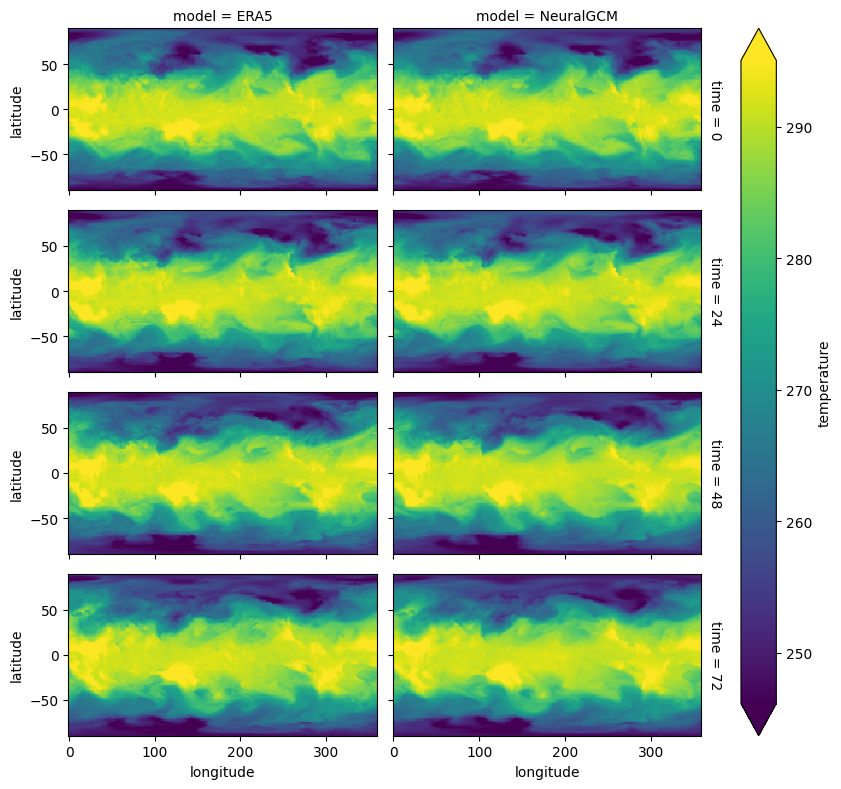

In [11]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.temperature.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [18]:
shapefile = '/content/drive/My Drive/Unbc/Shapefile/CAN_adm0.shp'

In [19]:
gdf = gpd.read_file(shapefile)
gdf

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,42,CAN,Canada,41,CAN,Canada,CANADA,Canada,Canada,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-65.64694 43.41778, -65.64667 ..."


In [27]:
combined_ds = combined_ds.temperature.rio.write_crs("epsg:4326", inplace=True)
combined_ds = combined_ds.rio.clip(gdf.geometry.apply(mapping), all_touched = True)
combined_ds

NoDataInBounds: No data found in bounds. Data variable: temperature